### Import Dependencies

In [1]:
import wikipedia
import pandas as pd
import json
import requests
import numpy as np
from bs4 import BeautifulSoup as bs
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

### Read the data from 1st data source

In [2]:
# Read the data from CSV file 
spotdf = pd.read_csv("Resources/top2018.csv")

In [3]:
# Create and display the dataframe
newspot_df=spotdf.drop(columns=['id','key','mode','acousticness','instrumentalness','liveness','tempo','duration_ms','time_signature'])
newspot_df = newspot_df.rename(columns={"name":"Name","artists":"Artist","danceability":"Danceability","energy":"Energy","loudness":"Loudness","speechiness":"Speechiness","valence":"Valence"})
newspot_df

,Name,Artist,Danceability,Energy,Loudness,Speechiness,Valence
0,God's Plan,Drake,0.754,0.449,-9.211,0.1090,0.3570
1,SAD!,XXXTENTACION,0.740,0.613,-4.880,0.1450,0.4730
2,rockstar (feat. 21 Savage),Post Malone,0.587,0.535,-6.090,0.0898,0.1400
3,Psycho (feat. Ty Dolla $ign),Post Malone,0.739,0.559,-8.011,0.1170,0.4390
4,In My Feelings,Drake,0.835,0.626,-5.833,0.1250,0.3500
5,Better Now,Post Malone,0.680,0.563,-5.843,0.0454,0.3740
6,I Like It,Cardi B,0.816,0.726,-3.998,0.1290,0.6500
7,One Kiss (with Dua Lipa),Calvin Harris,0.791,0.862,-3.240,0.1100,0.5920
8,IDGAF,Dua Lipa,0.836,0.544,-5.975,0.0943,0.5100
9,FRIENDS,Marshmello,0.626,0.880,-2.384,0.0504,0.5340


In [4]:
# Group the dataframe by "Artist" and take averages
spot_df = newspot_df.groupby(["Artist"]).mean()
spot_df.head()

,Danceability,Energy,Loudness,Speechiness,Valence
Artist,,,,,
5 Seconds of Summer,0.5960,0.8540,-5.1140,0.4630,0.152
6ix9ine,0.9310,0.3870,-9.1270,0.4120,0.376
Anitta,0.7750,0.6790,-4.9850,0.1350,0.619
Anne-Marie,0.6970,0.6830,-2.8810,0.1170,0.603
Ariana Grande,0.6505,0.6855,-5.7205,0.0576,0.311


### Scrape the data from 2nd data source

In [5]:
# URL to scrape the data
links = []
artists = []
base_url = 'https://247wallst.com/special-report/2019/01/10/100-most-popular-musicians-on-tour-in-2019/'
for i in range(2, 12):
    links.append(base_url + str(i))

for url in links:
    response = requests.get(url)
    soup = bs(response.text, 'html.parser')
    
    divs = soup.find_all('div', class_='pubentry-wrapper')
    for div in divs:
        artist_info = {}
        title_span = div.find('span', class_='title-bullet')
        artists_id_name = title_span.find('strong').text
        artist_id = artists_id_name.split(".")[0]
        artist_info['artist_id'] = artist_id
        artist_name = artists_id_name.split(".")[1].strip()
        artist_info['artist_name'] = artist_name
        
        bullet_spans = div.find_all('span', class_='value-bullet')
        no_of_shows = bullet_spans[0].text.strip()
        no_of_shows = no_of_shows.split(":")[1]
        artist_info['no_of_shows'] = no_of_shows
        followers = bullet_spans[1].text.strip()
        followers = followers.split(":")[1]
        artist_info['followers'] = followers
        recent_albums = bullet_spans[2].text.strip()
        recent_albums = recent_albums.split(":")[1]
        artist_info['recent_albums'] = recent_albums
        
        artists.append(artist_info)

In [6]:
# Create and display the dataframe
artists_df = pd.DataFrame(artists)
artists_df.head()

,artist_id,artist_name,followers,no_of_shows,recent_albums
0,100,Incubus,"675,465",4,8 (2017)
1,99,Kodak Black,"369,978",1,Dying to Live (2018)
2,98,Diplo,"605,749",19,Florida (2004)
3,97,"Tyler, The Creator","647,691",2,Flower Boy (2017)
4,96,Wu-Tang Clan,"449,643",4,Once Upon a Time in Shaolin (2015)


In [7]:
# Rename the columns in the dataframe
artists_df = artists_df.rename(columns={"artist_name":"Artist","artist_id":"Artist Id","followers":"# of Followers","no_of_shows":"# of Shows","recent_albums":"Recent Album"})

### Merge the two data sources

In [8]:
spotify_final = pd.merge(artists_df, spot_df, how="left", on=["Artist"])

In [9]:
# Drop duplicates
spotify_final = spotify_final.dropna() 

In [10]:
# Drop the column 'Artist Id'
spotify_final = spotify_final.drop(columns='Artist Id')
spotify_final

,Artist,# of Followers,# of Shows,Recent Album,Danceability,Energy,Loudness,Speechiness,Valence
13,Marshmello,"348,373",3,Joytime II (2018),0.611000,0.811000,-2.742000,0.06030,0.497000
32,Khalid,"605,494",3,American Teen (2017),0.753000,0.593500,-5.988500,0.04350,0.366000
35,Zedd,"887,638",10,True Colors (2015),0.753000,0.657000,-3.061000,0.04490,0.437000
42,Bebe Rexha,"414,348",1,Expectations (2018),0.642000,0.772000,-6.610000,0.08480,0.589000
59,G-Eazy,"765,101",1,The Beautiful & Damned (2017),0.589000,0.731000,-6.343000,0.08680,0.191000
62,Tyga,"985,112",3,Kyoto (2017),0.884000,0.559000,-7.442000,0.12000,0.342000
75,Shawn Mendes,"766,193",86,Shawn Mendes (2018),0.622000,0.712000,-7.321000,0.06600,0.487000
77,Migos,"737,273",4,Culture II (2018),0.862000,0.722000,-5.465000,0.23500,0.452000
83,Travis Scott,"766,831",30,Astroworld (2018),0.834000,0.730000,-3.714000,0.22200,0.446000
91,Imagine Dragons,"1,933,268",3,Origins (2018),0.690500,0.801000,-4.603500,0.08590,0.477000


### Connect to MySQL Database

In [11]:
# Create a connection to the database
rds_connection_string = "root:ritu1990@127.0.0.1/spotipy"
engine = create_engine(f"mysql://{rds_connection_string}")

### Check if the tables exist

In [12]:
# Display the tables in the database
engine.table_names()

['artists']

### Use pandas to load csv converted DataFrame into database

In [13]:
spotify_final.to_sql(name="artists", con=engine, if_exists="append", index=False)

### Confirm data has been added by querying the artists table

In [14]:
pd.read_sql_query('select * from artists', con=engine).head()

,artist,# of followers,# of shows,recent album,danceability,energy,loudness,speechiness,valence
0,Marshmello,"348,373",3,Joytime II (2018),0.611,0.8110,-2.7420,0.0603,0.497
1,Khalid,"605,494",3,American Teen (2017),0.753,0.5935,-5.9885,0.0435,0.366
2,Zedd,"887,638",10,True Colors (2015),0.753,0.6570,-3.0610,0.0449,0.437
3,Bebe Rexha,"414,348",1,Expectations (2018),0.642,0.7720,-6.6100,0.0848,0.589
4,G-Eazy,"765,101",1,The Beautiful & Damned (2017),0.589,0.7310,-6.3430,0.0868,0.191


### Plots of Top Touring Artists 

In [15]:
# Make lists of all the columns
artist_list = spotify_final['Artist'].values
followers_list = spotify_final['# of Followers'].values
danceability_list = spotify_final['Danceability'].values
energy_list = spotify_final['Energy'].values
loudness_list = spotify_final['Loudness'].values
speechiness_list = spotify_final['Speechiness'].values
valence_list = spotify_final['Valence'].values

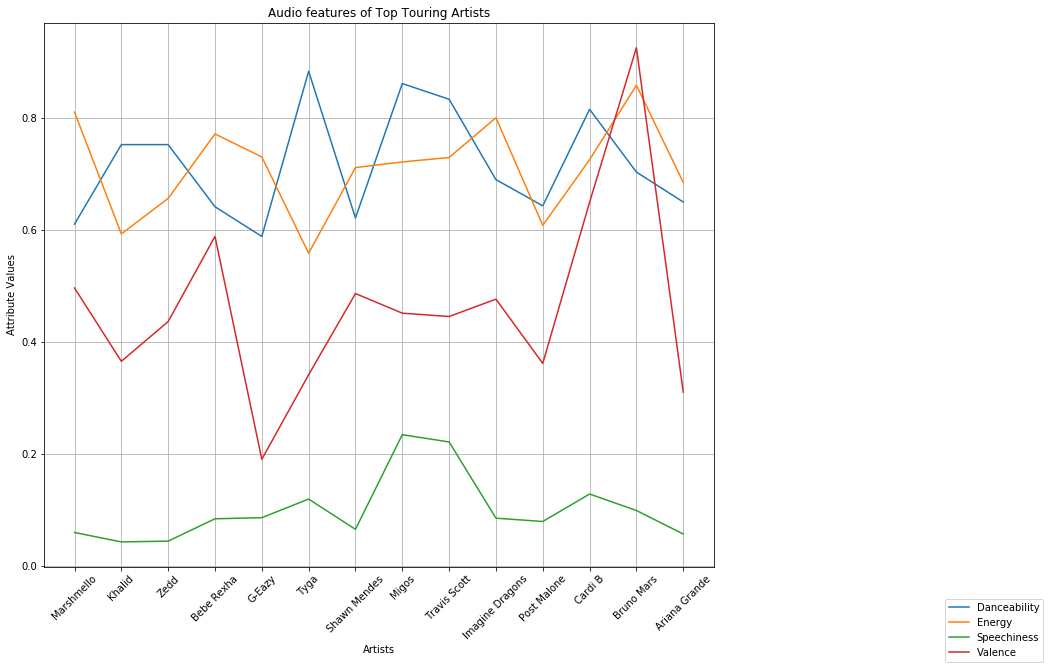

In [18]:
# Plotting the audio features - danceability, energy, speechiness and valence
danceability_plot = plt.plot(artist_list, danceability_list, label='Danceability')
energy_plot = plt.plot(artist_list, energy_list, label='Energy')
speechiness_plot = plt.plot(artist_list, speechiness_list, label='Speechiness')
valence_plot = plt.plot(artist_list, valence_list, label='Valence')

plt.title("Audio features of Top Touring Artists")
plt.xlabel("Artists")
plt.xticks(artist_list, rotation=45)
plt.ylabel("Attribute Values")

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plots = danceability_plot + energy_plot + speechiness_plot + valence_plot
labels = [l.get_label() for l in plots]
plt.legend(plots, labels, loc='upper right', bbox_to_anchor=(1.5, -0.05))
plt.grid()
plt.savefig("Images/Audio features of Top Touring Artists.jpg")
plt.show()

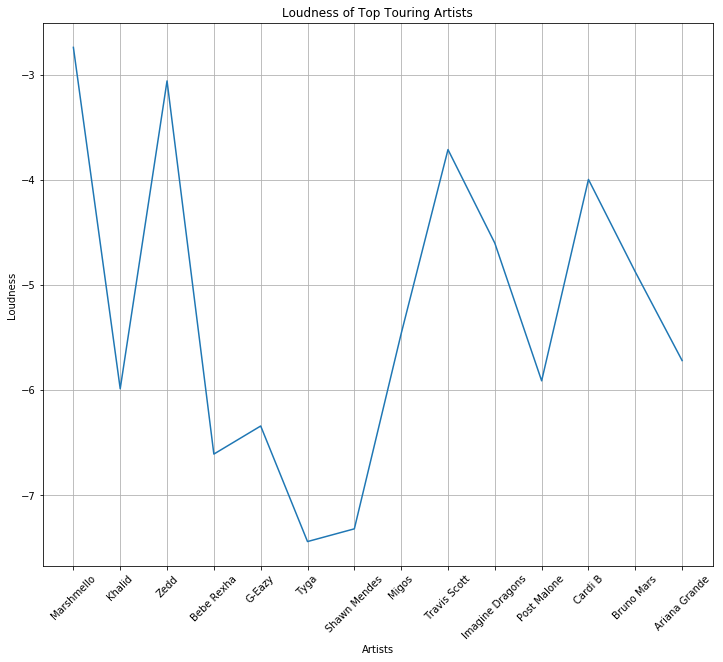

In [20]:
# Plotting the loudness of each artist
loudness_plot = plt.plot(artist_list, loudness_list, label='Loudness')

plt.title("Loudness of Top Touring Artists")
plt.xlabel("Artists")
plt.xticks(artist_list, rotation=45)
plt.ylabel("Loudness")

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.grid()
plt.savefig("Images/Loudness of Top Touring Artists.jpg")
plt.show()